<a href="https://colab.research.google.com/github/puneethkumarvydya/Capstone-Project/blob/Ganesh's-Branch/Capstone_Project_AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection 

In [ ]:
pip install pydicom

     |████████████████████████████████| 1.9MB 5.2MB/s 


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
import pydicom as dicom # for reading dcom files
import os
from os import listdir
from os.path import isfile, join
# print(os.listdir("../input"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/projects/capstone_project/Capestone/')
#path = ('.')
os.listdir()

['Pneumonia Detection Challenge Brief.pdf',
 'Interim Report Format.pdf',
 'Final Report Format.pdf',
 'rsna-pneumonia-detection-challenge.zip',
 'Capstone_Project_AIML.ipynb',
 'stage_2_test_images',
 'stage_2_train_images',
 'stage_2_train_labels.csv',
 'GCP Credits Request Link - RSNA.txt',
 'stage_2_sample_submission.csv',
 'stage_2_detailed_class_info.csv',
 'images_more_data_training.csv']

## Data Overview
### Stage 2 Images - `stage_2_train_images.zip` and `stage_2_test_images.zip`
- images for the current stage. Filenames are also patient names.

### Stage 2 Labels - `stage_2_train_labels.csv` and Stage 2 Sample Submission `stage_2_sample_submission.csv`
- Which provides the IDs for the test set, as well as a sample of what your submission should look like

### Stage 2 Detailed Info - `stage_2_detailed_class_info.csv`
- contains detailed information about the positive and negative classes in the training set, and may be used to build more nuanced models.

In [ ]:
# Images Example
train_images_dir = '/content/drive/My Drive/projects/capstone_project/Capestone/stage_2_train_images'
#train_images_dir = '../input/stage_1_train_images/'
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
test_images_dir = '/content/drive/My Drive/projects/capstone_project/Capestone/stage_2_test_images'
#test_images_dir = '../input/stage_1_test_images/'
test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]
print('5 Training images', train_images[:5]) # Print the first 5

5 Training images ['5fabbfac-9c58-4fb1-bfee-979526adcc14.dcm', '5fb17b91-e490-4f40-bc6b-7955028058c8.dcm', '5faf58cf-a01b-4b8a-8456-e63dedde1b68.dcm', '5fb1f7f4-d9ee-45d0-b335-fed129ce68dd.dcm', '5fb43479-d9a4-4c32-bed3-f63ae1462216.dcm']


In [ ]:
print('Number of train images:', len(train_images))
print('Number of test images:', len(test_images))

Number of train images: 26684
Number of test images: 3000


In [ ]:
train_labels = pd.read_csv("stage_2_train_labels.csv")
train_labels.shape

(30227, 6)

## Plot a few training images from `stage_2_train_images.zip`

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    #ds = dicom.dcmread(train_images_dir + train_images[i])
    ds = dicom.dcmread(train_images_dir + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

FileNotFoundError: ignored

<Figure size 2000x1000 with 0 Axes>

## Look at labels in `stage_2_train_labels.csv`

In [ ]:
#train_labels = pd.read_csv('../input/stage_1_train_labels.csv')
train_labels = pd.read_csv('/content/drive/My Drive/projects/capstone_project/Capestone/stage_2_train_labels.csv')
train_labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

## Distribution of Positive Labels

In [ ]:
# Number of positive targets
print(round((8964 / (8964 + 20025)) * 100, 2), '% of the examples are positive')
pd.DataFrame(train_labels.groupby('Target')['patientId'].count())

30.92 % of the examples are positive


patientId
Target           
0           20672
1            9555

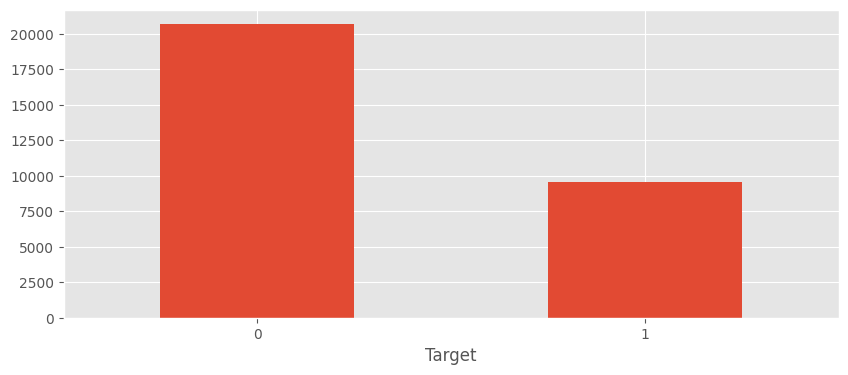

In [ ]:
# Distribution of Target in Training Set
plt.style.use('ggplot')
plot = train_labels.groupby('Target') \
    .count()['patientId'] \
    .plot(kind='bar', figsize=(10,4), rot=0)

## Size of the impacted area
We can make a new feature called "area" to the train labels data to see what the distribution of areas label look like.

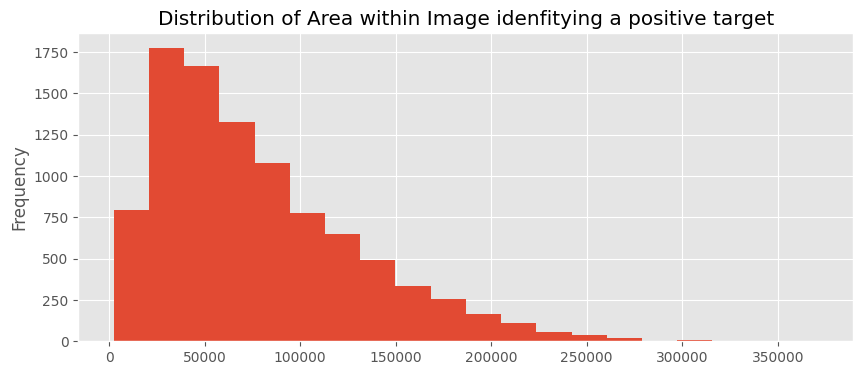

In [ ]:
plt.style.use('ggplot')
train_labels['area'] = train_labels['width'] * train_labels['height']
plot = train_labels['area'].plot(kind='hist',
                          figsize=(10,4),
                          bins=20,
                          title='Distribution of Area within Image idenfitying a positive target')

# Plotting Boxes around Images


In [ ]:

def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '/content/drive/My Drive/projects/capstone_project/Capestone/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

parsed = parse_data(train_labels)

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        #rgb = np.floor(np.random.rand(3) * 256).astype('int')
        rgb = [255, 251, 204] # Just use yellow
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=15)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=2):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

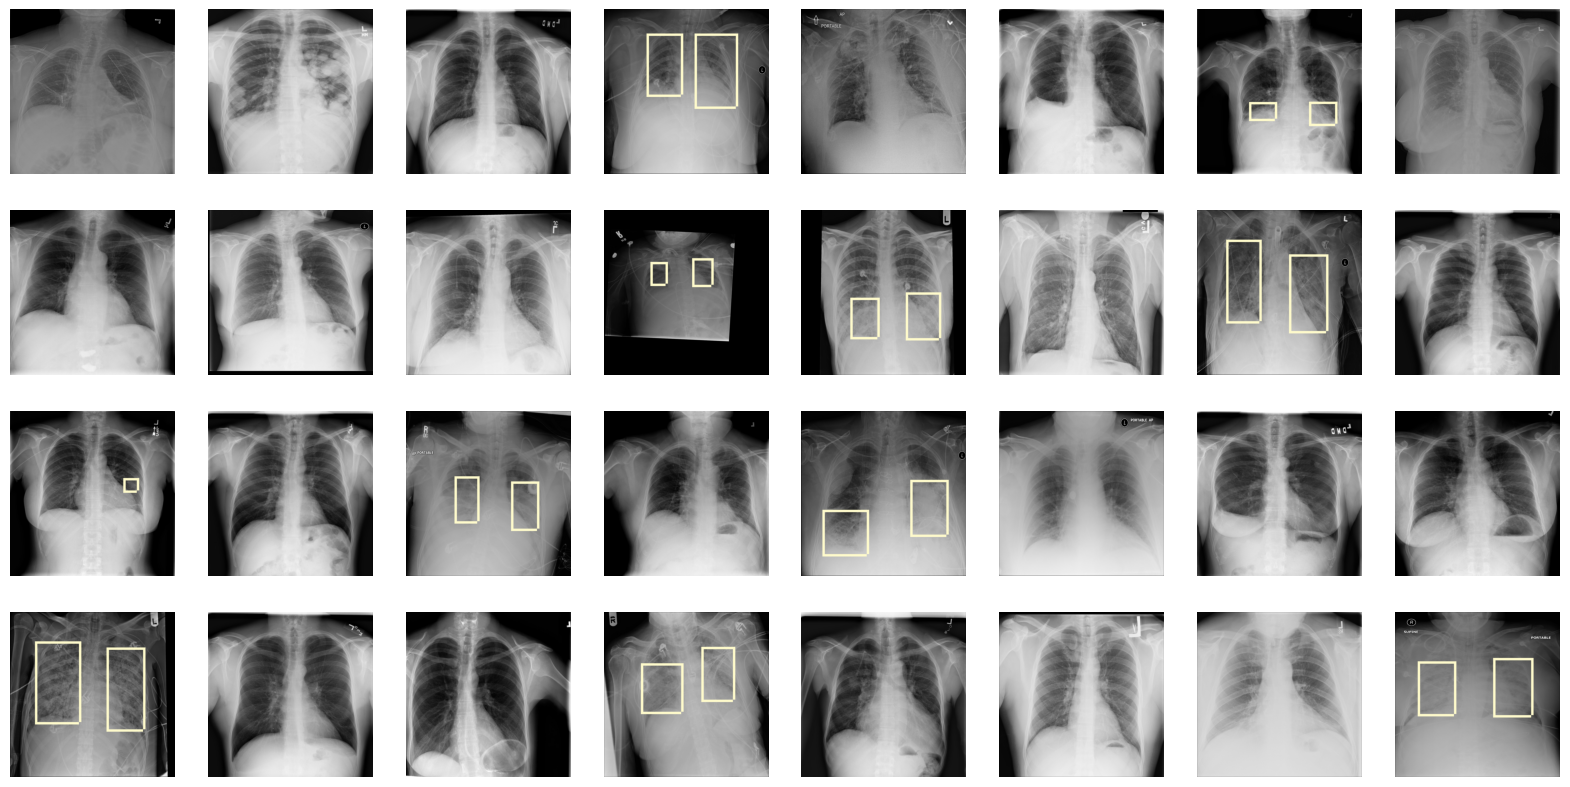

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[train_labels['patientId'].unique()[i]])
    fig.add_subplot

## A closer look at a Positive and Negative Example

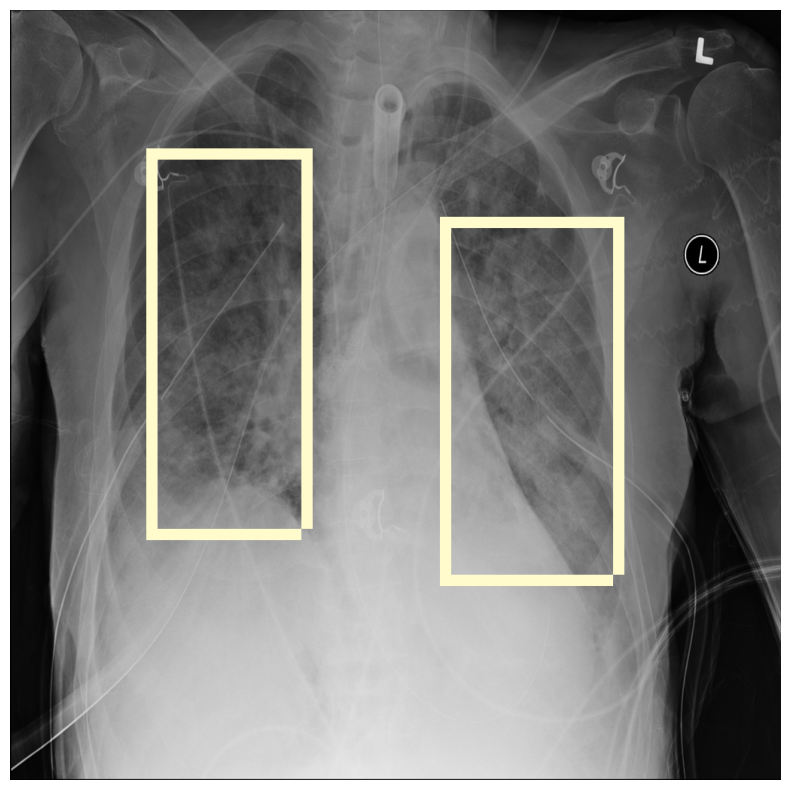

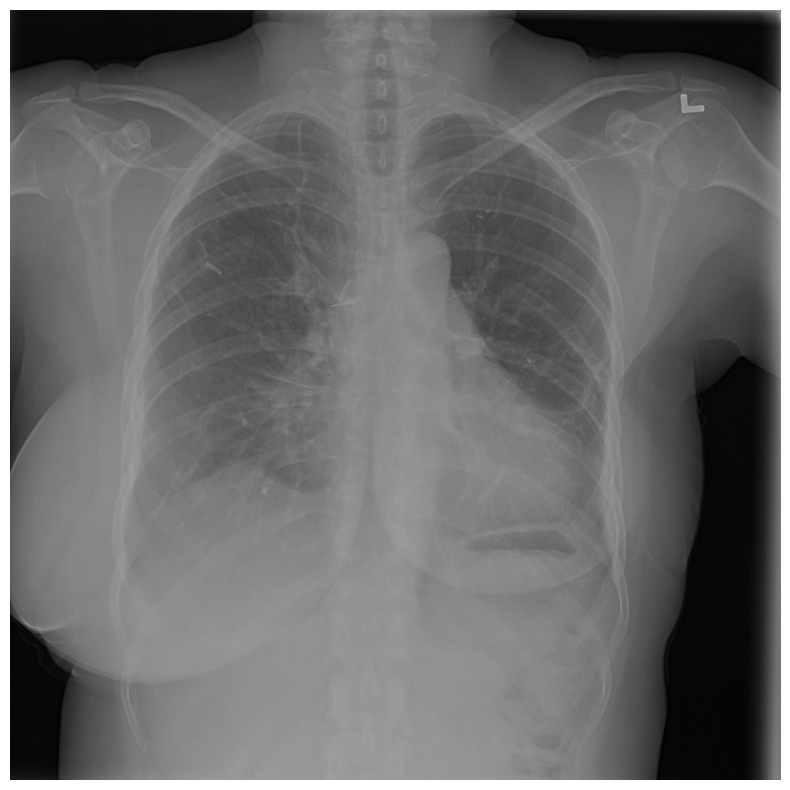

In [ ]:
fig=plt.figure(figsize=(20, 10))
draw(parsed[train_labels['patientId'].loc[20]])
plt.show()
fig=plt.figure(figsize=(20, 10))
draw(parsed[train_labels['patientId'].loc[10]])
plt.show()

# EDA of Detailed Class Info

In [ ]:
image_path = 'stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'
ds = dicom.dcmread(image_path, force = True)

ds
#plt.imshow(ds.pixel_array,cmap='gray')

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.4475.1517874307.936345
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [ ]:
detailed_class_info = pd.read_csv('/content/drive/My Drive/projects/capstone_project/Capestone/stage_2_detailed_class_info.csv')
detailed_class_info.groupby('class').count()

patientId
class                                  
Lung Opacity                       9555
No Lung Opacity / Not Normal      11821
Normal                             8851

In [ ]:
detailed_class_info.head(10)

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity

In [ ]:
detailed_class_info['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

In [ ]:
detailed_class_info.describe

<bound method NDFrame.describe of                                   patientId                         class
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2      00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4      00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
...                                     ...                           ...
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8                  Lung Opacity
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba                        Normal
30224  c1f6b555-2eb1-4231-98f6-50a963976431                        Normal
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity

[30227 rows x 2 columns]>

In [ ]:
train_labels.describe()

x            y  ...        Target           area
count  9555.000000  9555.000000  ...  30227.000000    9555.000000
mean    394.047724   366.839560  ...      0.316108   77523.448038
std     204.574172   148.940488  ...      0.464963   51807.689206
min       2.000000     2.000000  ...      0.000000    2320.000000
25%     207.000000   249.000000  ...      0.000000   37535.500000
50%     324.000000   365.000000  ...      0.000000   64829.000000
75%     594.000000   478.500000  ...      1.000000  106491.500000
max     835.000000   881.000000  ...      1.000000  371184.000000

[8 rows x 6 columns]

In [ ]:
train_labels['Target'].unique()

array([0, 1])

In [ ]:
detailed_class_info['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

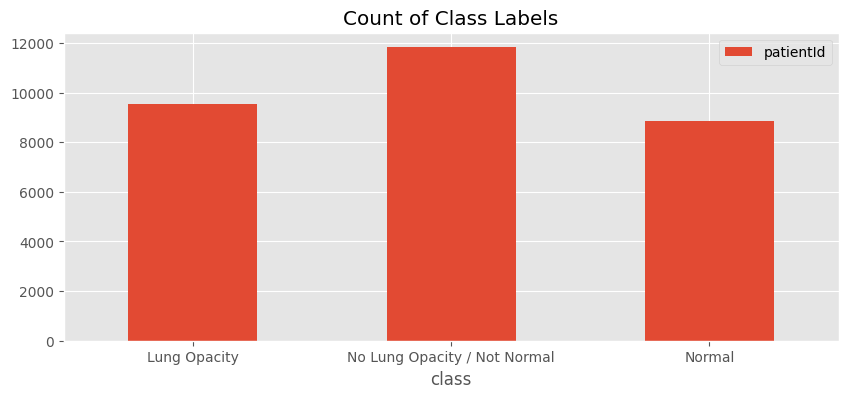

In [ ]:
plt.style.use('ggplot')
plot = detailed_class_info.groupby('class').count().plot(kind='bar',
                                                  rot=0,
                                                  title='Count of Class Labels',
                                                  figsize=(10,4))

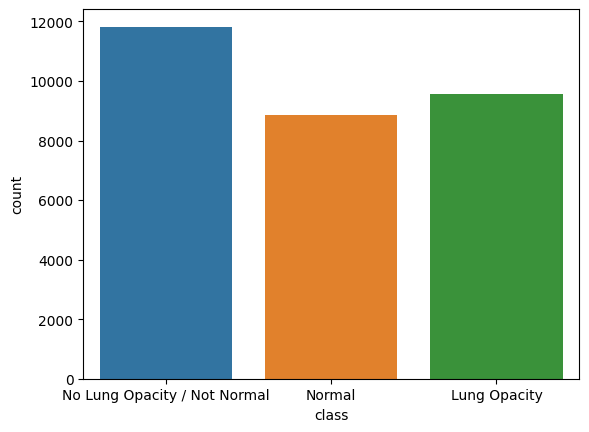

In [ ]:
import seaborn as sb

sb.countplot(x='class',data=detailed_class_info)

In [ ]:
count_labels_per_patient = detailed_class_info.groupby('patientId').count()

In [ ]:
count_labels_per_patient

class
patientId                                  
0004cfab-14fd-4e49-80ba-63a80b6bddd6      1
000924cf-0f8d-42bd-9158-1af53881a557      1
000db696-cf54-4385-b10b-6b16fbb3f985      2
000fe35a-2649-43d4-b027-e67796d412e0      2
001031d9-f904-4a23-b3e5-2c088acd19c6      2
...                                     ...
fffb2395-8edd-4954-8a89-ffe2fd329be3      2
fffba05a-1635-4545-9bbd-57ad4cfe8d27      1
fffc95b5-605b-4226-80ab-62caec682b22      1
fffcff11-d018-4414-971a-a7cefa327795      1
fffec09e-8a4a-48b1-b33e-ab4890ccd136      1

[26684 rows x 1 columns]

# Images of Each Label Type

In [ ]:
opacity = detailed_class_info \
    .loc[detailed_class_info['class'] == 'Lung Opacity'] \
    .reset_index()
not_normal = detailed_class_info \
    .loc[detailed_class_info['class'] == 'No Lung Opacity / Not Normal'] \
    .reset_index()
normal = detailed_class_info \
    .loc[detailed_class_info['class'] == 'Normal'] \
    .reset_index()

## ** Lung Opacity** Examples

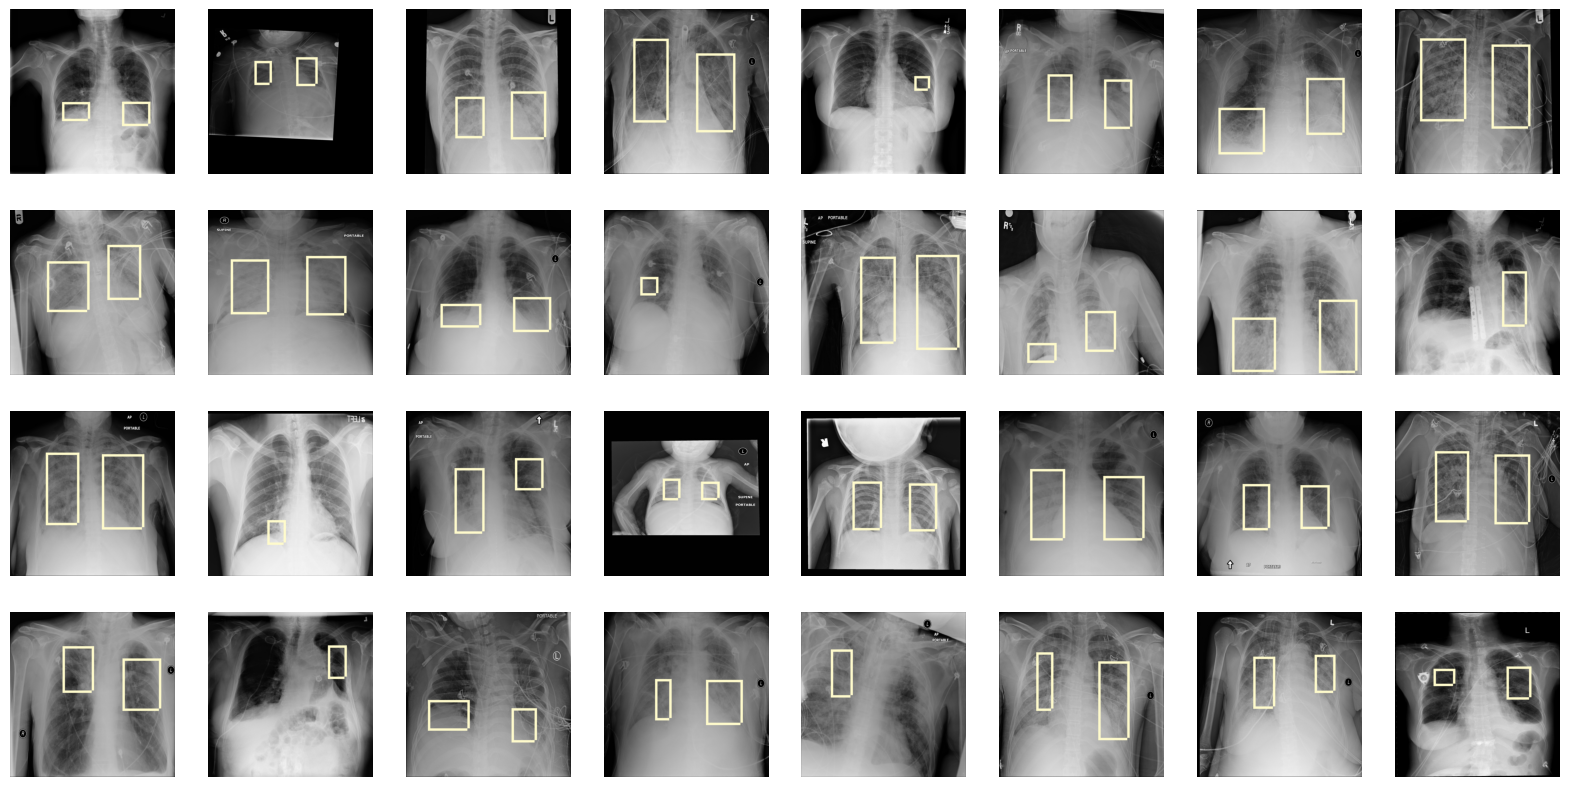

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[opacity['patientId'].unique()[i]])

## ** No Lung Opacity / Not Normal** Examples

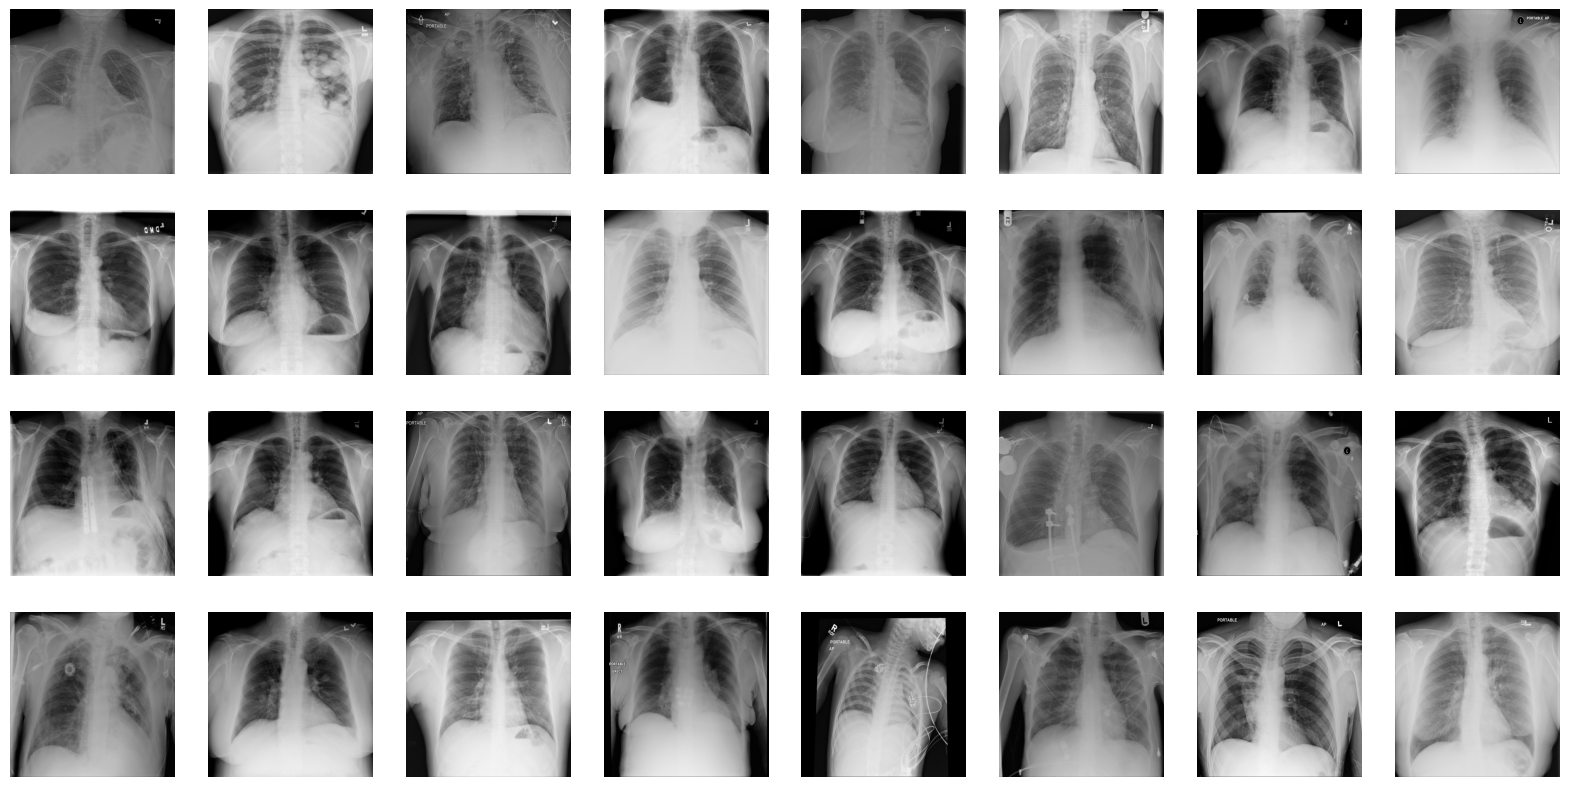

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[not_normal['patientId'].loc[i]])

## **Normal** Examples

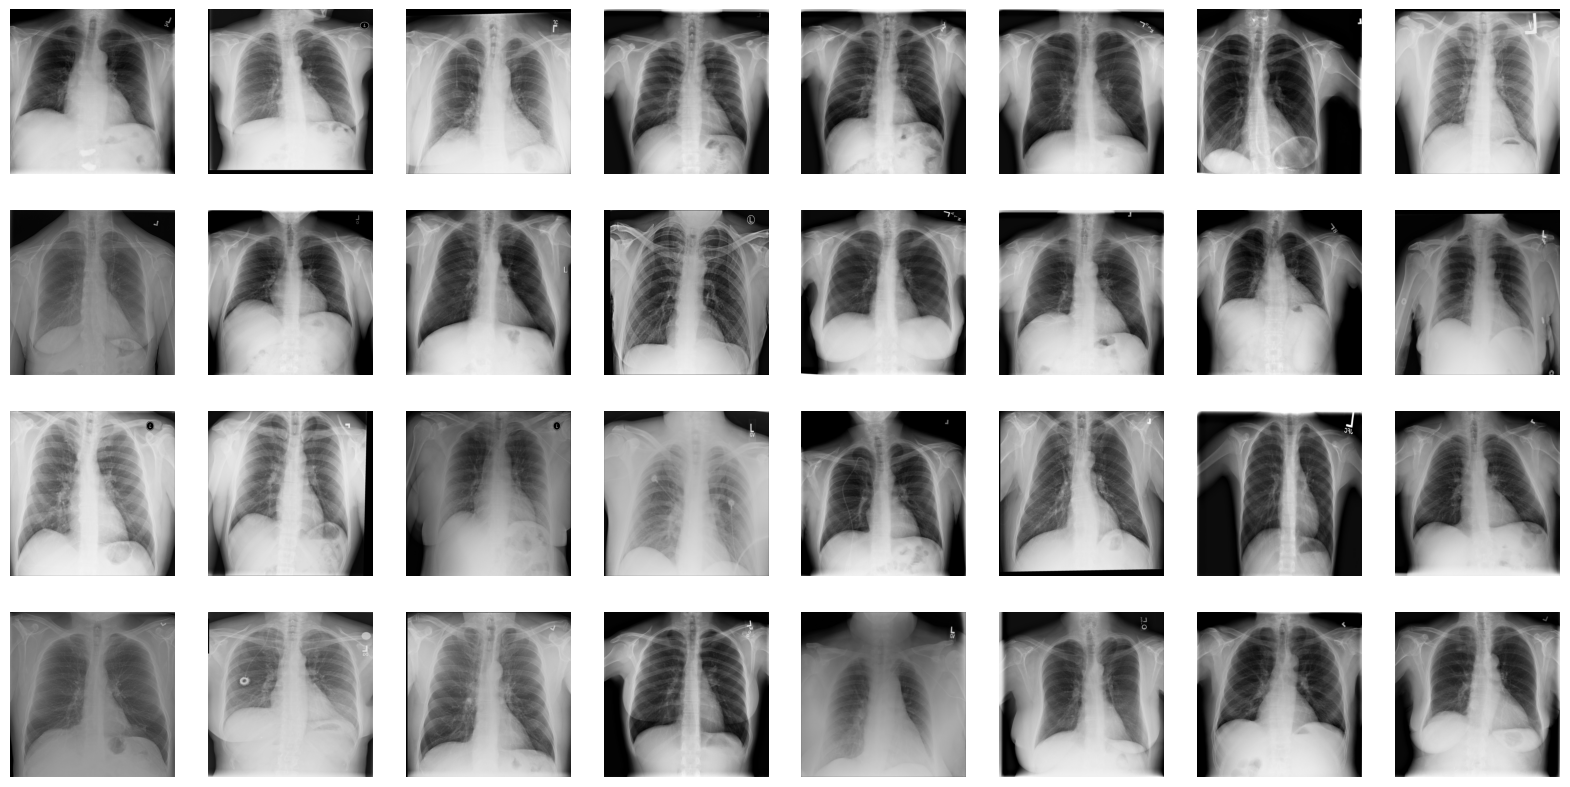

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(20, 10))
columns = 8; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[normal['patientId'].loc[i]])

# Side By Side Compare of Opacity/Not Normal/Normal

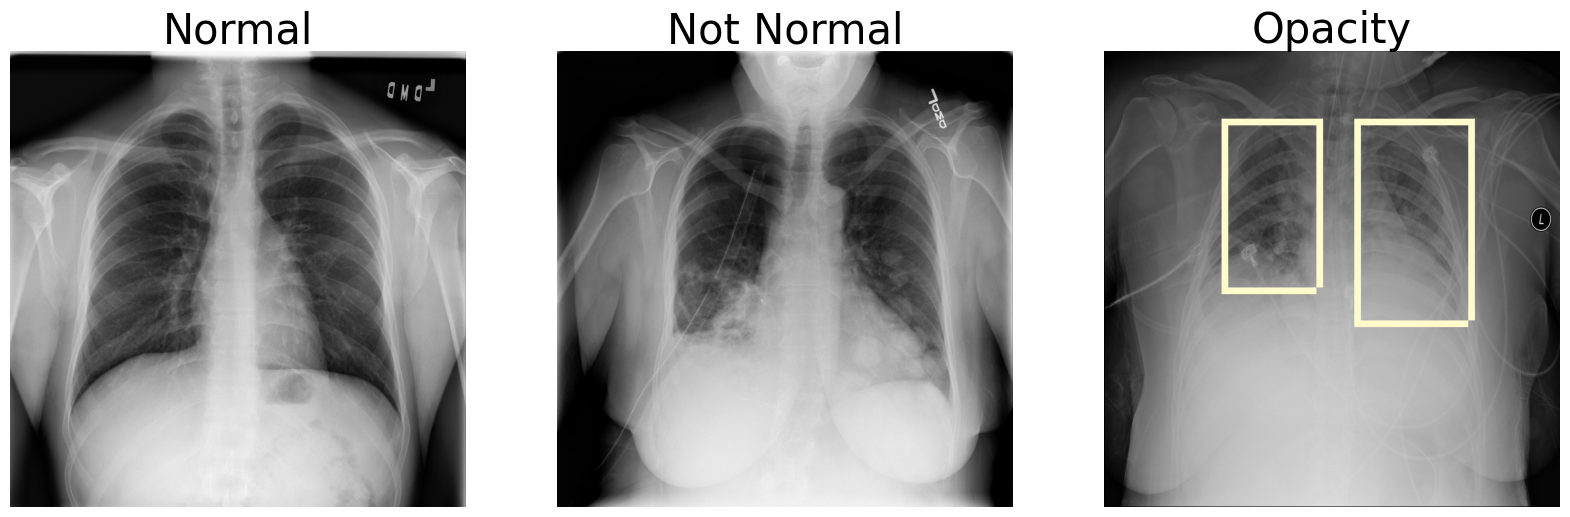

In [ ]:
fig=plt.figure(figsize=(20, 10))
columns = 3; rows = 1
fig.add_subplot(rows, columns, 1).set_title("Normal", fontsize=30)
draw(parsed[normal['patientId'].unique()[0]])
fig.add_subplot(rows, columns, 2).set_title("Not Normal", fontsize=30)
# ax2.set_title("Not Normal", fontsize=30)
draw(parsed[not_normal['patientId'].unique()[0]])
fig.add_subplot(rows, columns, 3).set_title("Opacity", fontsize=30)
# ax3.set_title("Opacity", fontsize=30)
draw(parsed[opacity['patientId'].unique()[0]])

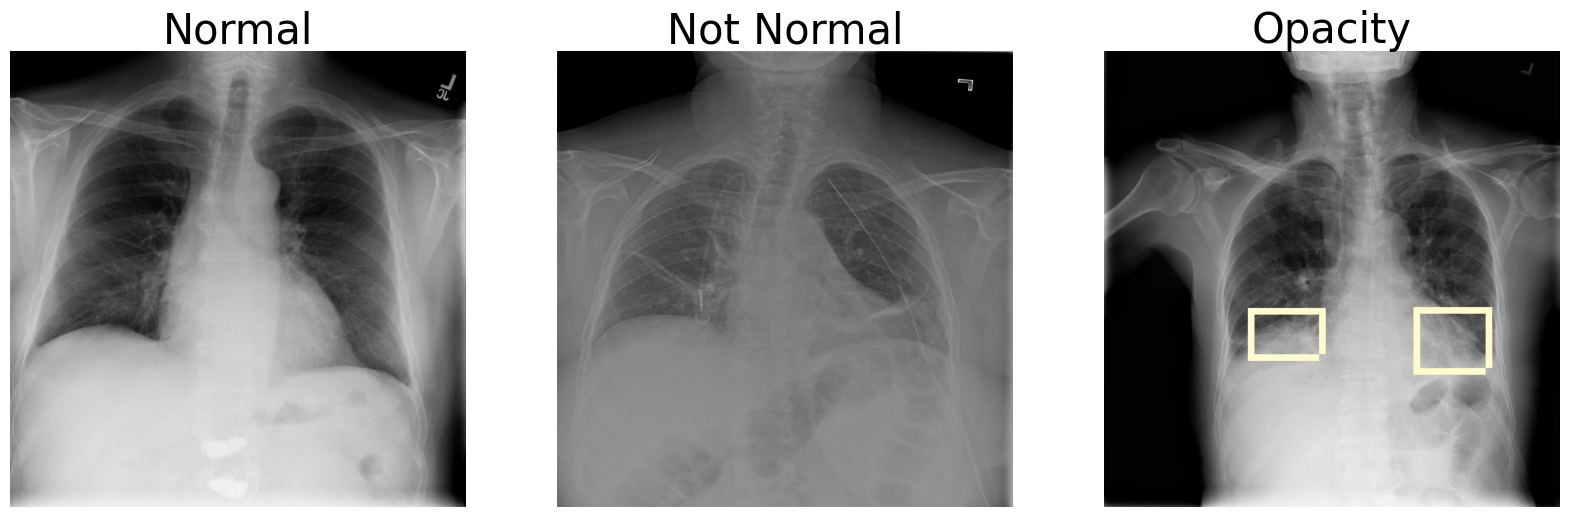

In [ ]:
fig=plt.figure(figsize=(20, 10))
columns = 3; rows = 1
fig.add_subplot(rows, columns, 1).set_title("Normal", fontsize=30)
draw(parsed[normal['patientId'].unique()[1]])
fig.add_subplot(rows, columns, 2).set_title("Not Normal", fontsize=30)
# ax2.set_title("Not Normal", fontsize=30)
draw(parsed[not_normal['patientId'].unique()[1]])
fig.add_subplot(rows, columns, 3).set_title("Opacity", fontsize=30)
# ax3.set_title("Opacity", fontsize=30)
draw(parsed[opacity['patientId'].unique()[1]])

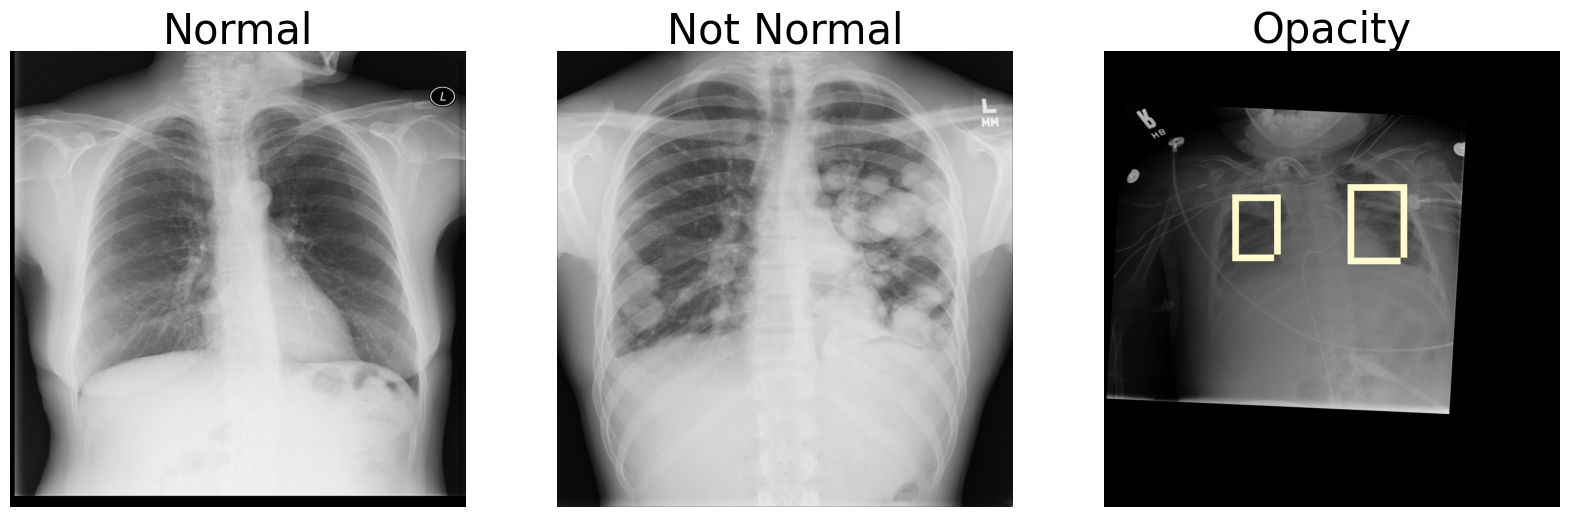

In [ ]:
fig=plt.figure(figsize=(20, 10))
columns = 3; rows = 1
fig.add_subplot(rows, columns, 1).set_title("Normal", fontsize=30)
draw(parsed[normal['patientId'].unique()[2]])
fig.add_subplot(rows, columns, 2).set_title("Not Normal", fontsize=30)
# ax2.set_title("Not Normal", fontsize=30)
draw(parsed[not_normal['patientId'].unique()[2]])
fig.add_subplot(rows, columns, 3).set_title("Opacity", fontsize=30)
# ax3.set_title("Opacity", fontsize=30)
draw(parsed[opacity['patientId'].unique()[2]])

# Number of Labels Per Patientid
patients have 0-4 labels, patients can have multiple labels.
(Only including ones with at least on label)

In [ ]:
count_labels_per_patient.reset_index().groupby('class').count()

patientId
class           
1          23286
2           3266
3            119
4             13

In [ ]:
# Patients with 4 Labels
count_labels_per_patient.sort_values('class', ascending=False).head()

class
patientId                                  
76f71a93-8105-4c79-a010-0cfa86f0061a      4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5      4
0ab261f9-4eb5-42ab-a9a5-e918904d6356      4
0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d      4
1c44e0a4-4612-438f-9a83-8d5bf919cb67      4

In [ ]:
detailed_class_info.loc[detailed_class_info['patientId'] == '7d674c82-5501-4730-92c5-d241fd6911e7']

patientId         class
12251  7d674c82-5501-4730-92c5-d241fd6911e7  Lung Opacity
12252  7d674c82-5501-4730-92c5-d241fd6911e7  Lung Opacity
12253  7d674c82-5501-4730-92c5-d241fd6911e7  Lung Opacity
12254  7d674c82-5501-4730-92c5-d241fd6911e7  Lung Opacity

# Closer Look of Each Type

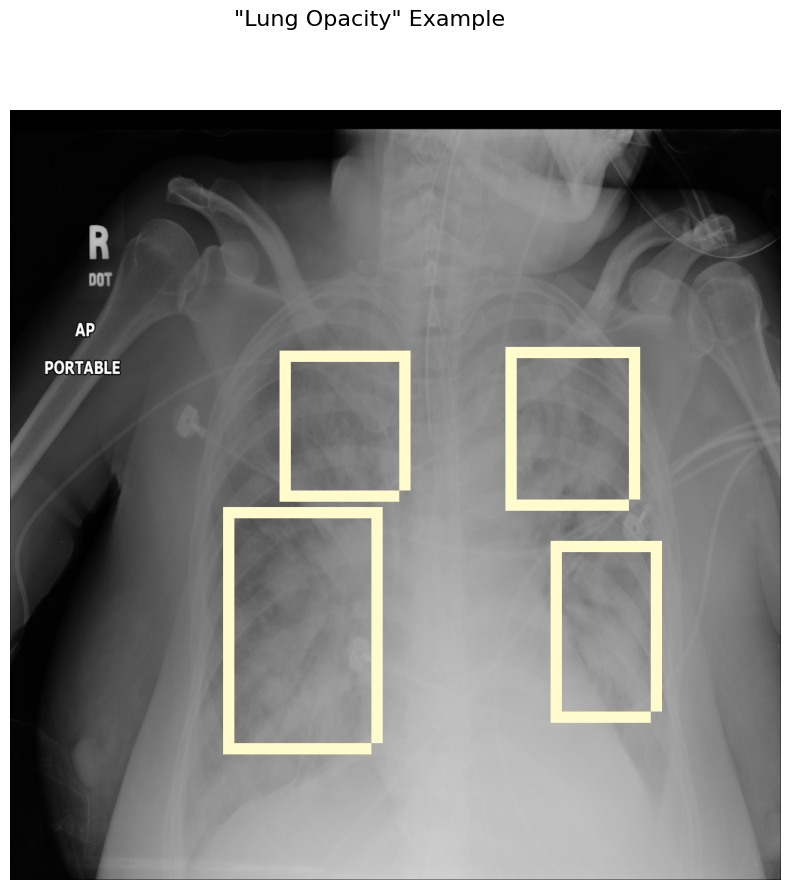

In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.suptitle('"Lung Opacity" Example', fontsize=16)
draw(parsed['7d674c82-5501-4730-92c5-d241fd6911e7'])

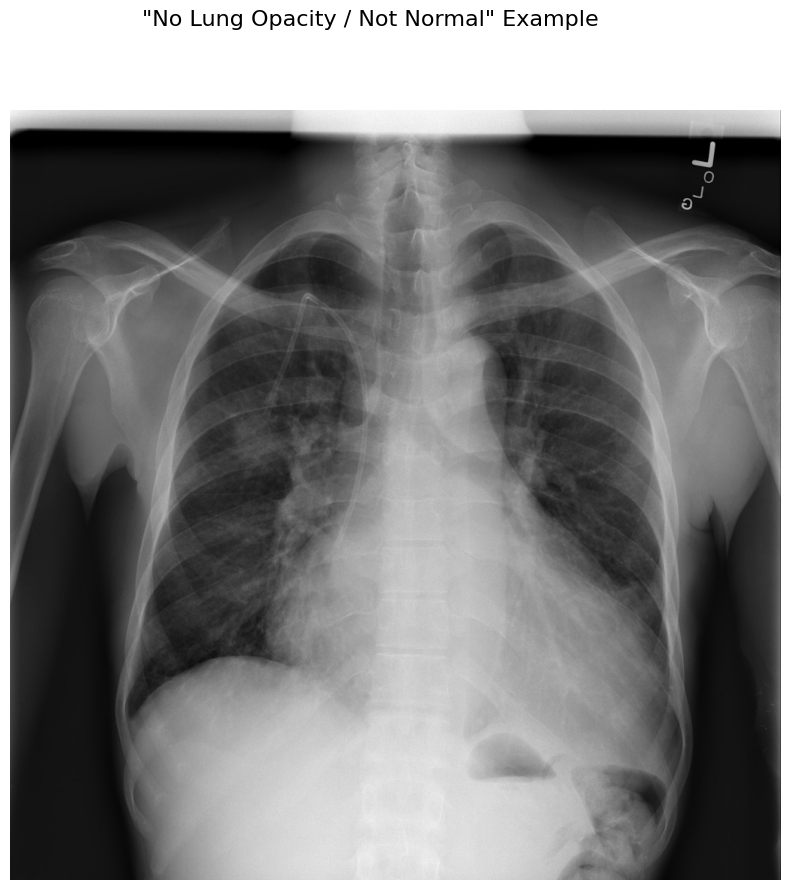

In [ ]:
not_normal = detailed_class_info.loc[detailed_class_info['class'] == 'No Lung Opacity / Not Normal']
not_normal_example = not_normal['patientId']
fig=plt.figure(figsize=(20, 10))
plt.suptitle('"No Lung Opacity / Not Normal" Example', fontsize=16)
draw(parsed['019e035e-2f82-4c66-a198-57422a27925f'])

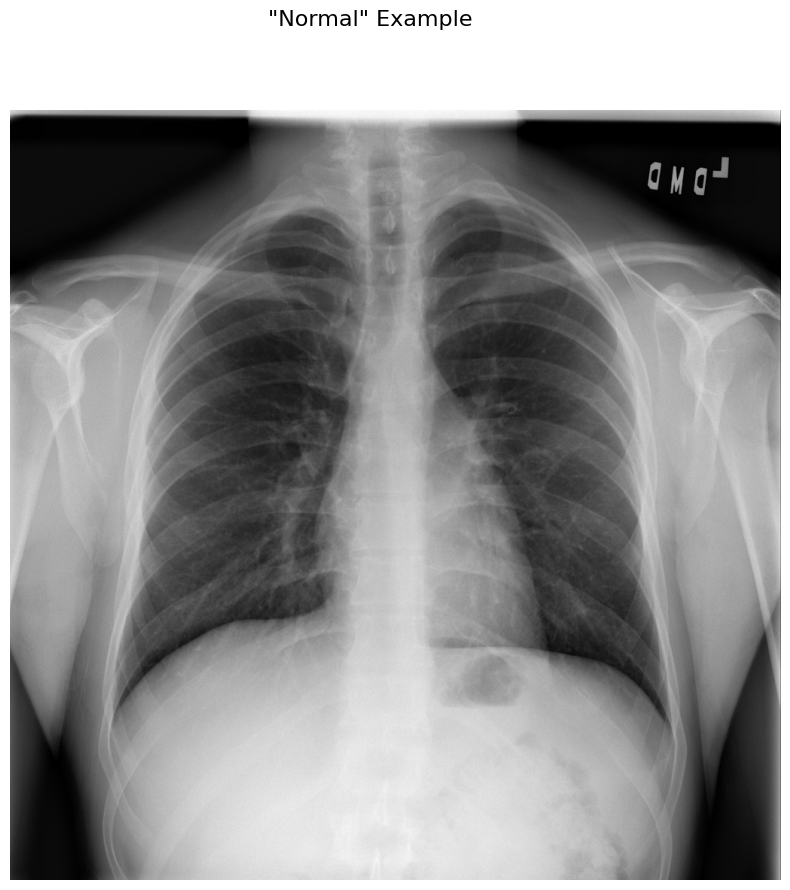

In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.suptitle('"Normal" Example', fontsize=16)
draw(parsed['003d8fa0-6bf1-40ed-b54c-ac657f8495c5'])

# What does the submission look like?

In [ ]:
pd.read_csv('/content/drive/My Drive/projects/capstone_project/Capestone/stage_2_sample_submission.csv').head()

patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100

In [ ]:
train_labels['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [ ]:
train_labels.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
area         20672
dtype: int64